<a href="https://colab.research.google.com/github/abdoufermat5/deep-Learning-ProjetDIC2/blob/main/Text_Generation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Generation model

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Polytechnique"))

(['P', 'o', 'l', 'y', 't', 'e', 'c', 'h', 'n', 'i', 'q', 'u'],
 ['o', 'l', 'y', 't', 'e', 'c', 'h', 'n', 'i', 'q', 'u', 'e'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Create training batches

In [ ]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Model

Ce modèle comporte trois couches:

* `tf.keras.layers.Embedding` : La couche d'entrée. Une table de consultation entraînable qui va faire correspondre chaque caractère-ID à un vecteur avec des dimensions `embedding_dim` ;
* `tf.keras.layers.GRU` : Un type de RNN avec la taille `units=rnn_units` 
* `tf.keras.layers.Dense` : La couche de sortie, avec des sorties de taille `vocab_size`. Elle sort un logit pour chaque caractère du vocabulaire. Ce sont les log-vraisemblances de chaque caractère selon le modèle.

In [ ]:
# longueur du vocabulaire
vocab_size = len(vocab)

# embedding dimension
embedding_dim = 256

# nombre de neurones du RNN
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([21, 11, 34, 12, 62, 37, 46, 40, 59, 17, 12, 29, 44, 20, 25, 35, 32,
       14, 34, 44,  5, 14, 33, 52, 25, 18, 21,  5, 40, 24, 17, 49, 18,  5,
       23,  3, 24, 58, 62, 39, 34, 65, 62,  6,  3, 23, 41, 16,  5,  7, 58,
       20, 20, 41, 50, 56, 11, 55, 46, 37, 21, 64, 52,  7, 41,  7, 63, 43,
       50, 56, 25, 56, 52, 27, 31, 51, 18, 10, 34, 34, 51, 56, 23, 18, 58,
       46,  7, 35, 62,  8, 27, 44, 39, 58, 41, 44, 39, 60, 49, 28])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"mind;\nWhat thou dost know of noble Gloucester's death,\nWho wrought it with the king, and who perform"

Next Char Predictions:
 b"H:U;wXgatD;PeGLVSAUe&ATmLEH&aKDjE&J!KswZUzw'!JbC&,sGGbkq:pgXHym,b,xdkqLqmNRlE3UUlqJEsg,Vw-NeZsbeZujO"


## Train the model

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss=loss)

In [ ]:
! mkdir training_checkpoints

mkdir: cannot create directory ‘training_checkpoints’: File exists


#### Pour enrégistrer les resultats époques par époques

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Entrainement

In [ ]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 25s 126ms/step - loss: 2.7427 - accuracy: 0.2766
Epoch 2/20
172/172 [==============================] - 23s 128ms/step - loss: 2.0038 - accuracy: 0.4143
Epoch 3/20
172/172 [==============================] - 24s 130ms/step - loss: 1.7214 - accuracy: 0.4901
Epoch 4/20
172/172 [==============================] - 24s 131ms/step - loss: 1.5572 - accuracy: 0.5331
Epoch 5/20
172/172 [==============================] - 24s 130ms/step - loss: 1.4566 - accuracy: 0.5591
Epoch 6/20
172/172 [==============================] - 24s 130ms/step - loss: 1.3878 - accuracy: 0.5761
Epoch 7/20
172/172 [==============================] - 24s 129ms/step - loss: 1.3356 - accuracy: 0.5890
Epoch 8/20
172/172 [==============================] - 24s 129ms/step - loss: 1.2908 - accuracy: 0.6005
Epoch 9/20
172/172 [==============================] - 23s 128ms/step - loss: 1.2512 - accuracy: 0.6105
Epoch 10/20
172/172 [==============================] - 24s 128ms/step - l

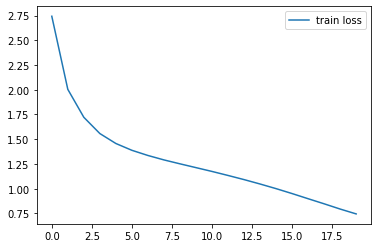

In [ ]:
from matplotlib import pyplot 
history = model.history
pyplot.plot(history.history['loss'], label='train loss') 
pyplot.legend() 
pyplot.show()

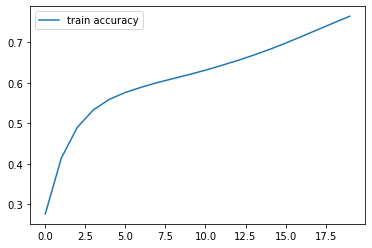

In [ ]:
from matplotlib import pyplot 
history = model.history
pyplot.plot(history.history['accuracy'], label='train accuracy') 
pyplot.legend() 
pyplot.show()

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Créez un masque pour empêcher la génération de "[UNK]".
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # mettre -inf aux mauvais index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # accomoder la taille a celle du vocabulaire
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    #conversion string -> id token
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # lancer le model
    
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # n'utiliser que la dernière prédiction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # appliquer un masque pour empêcher la génération de "[UNK]".
    predicted_logits = predicted_logits + self.prediction_mask

  
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    
    predicted_chars = self.chars_from_ids(predicted_ids)

   
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Let me entreat you.

BUCKINGHAM:
Why then, they live, I say! here comes King Lady--
Come, gentlemen, long our coach o'er away the realm;
For on that judgmen and drink out of his sin
To do him there as justice; yet as school-mind
That you had thereby neighbours.
Never for the voice o' the court,
Beserved their waking, think of his
Aboutly a present correction to the woo
That raised into earnest are held with you;
For God bount impossibing cooked afform'd Toward:
This is the war, where thou hast made good merry maid
To be the offering informited contracted
Tybalt closed with one benefity: I must
opposite but smelt as desperate, what shout is this
That you reprieve to pray when there die not.

Third Servant:
What, shall I drop tell? then every trubh
To her fortune wheels me hard. But in some merry must
Sent for thee. Lords, at your pleasure;
If you would hear your princely knee?
Where is the foolish and order? not?

Provost:
Well, your mother, as I see, and tell the queen, presentl

In [ ]:
tf.saved_model.save(one_step_model, 'text_generation')
one_step_reloaded = tf.saved_model.load('text_generation')

INFO:tensorflow:Assets written to: text_generation/assets


INFO:tensorflow:Assets written to: text_generation/assets


In [ ]:
!zip -r text_generation.zip text_generation

  adding: text_generation/ (stored 0%)
  adding: text_generation/saved_model.pb (deflated 90%)
  adding: text_generation/assets/ (stored 0%)
  adding: text_generation/variables/ (stored 0%)
  adding: text_generation/variables/variables.index (deflated 61%)
  adding: text_generation/variables/variables.data-00000-of-00001 (deflated 8%)
